In [2]:
import seaborn as sns
import pandas as pd
import os
import numpy as np
import math
from math import cos, sin, tanh

In [24]:
#Separating relavent and inrevelant part of the data from the raw txt files.

#--- Insert here ---
pp_id = '01'
position_of = 'Spot'
run = True
#-------------------

if run == True:
    # Define input and output file path
    rawfile = open('/Users/nanap/My project/Assets/TrackerData/'+ pp_id + position_of +'_position.txt', 'r')
    Lines = rawfile.readlines()

    path = './newdata/id_' + pp_id + '/' + position_of

    isExist = os.path.exists(path)
    isExist_pp =os.path.exists('./newdata/id_' + pp_id)

    if isExist == False:
        if isExist_pp== False:
            os.mkdir('./newdata/id_' + pp_id)
        os.mkdir(path)

    # Initialize count
    count = 1
    addline = False

    # Read the text file line by line 
    for line in Lines:
        print(line)
        if line == '--- Calibration ---\n':
            print('calibration')

        elif line == '--- Start ' + str(count) + ' ---\n':
            print('START')
            # Create new file with Start 
            newfile = open(path + '/' + pp_id + '_' + str(count) +'.txt', 'w')
            addline = True

        elif line == '--- End ' + str(count) + ' ---\n':
            print("END")
            addline = False
            newfile.close()
            count += 1
        else:    
            if addline==True:
                line = line.replace(",", "") # remove ',' between x and z 
                newfile.write(line) # add valid line to new txt file

            else:
                pass

    rawfile.close()

03:07:23:13 -1.089321, 1.335295

03:07:23:23 -1.089154, 1.3351

03:07:23:30 -1.089427, 1.335367

03:07:23:40 -1.089396, 1.335255

03:07:23:52 -1.08917, 1.335265

03:07:23:62 -1.089418, 1.335406

03:07:23:72 -1.089447, 1.335418

03:07:23:82 -1.089254, 1.335393

03:07:23:93 -1.089265, 1.335251

03:07:24:00 -1.089498, 1.335485

03:07:24:10 -1.089389, 1.335351

03:07:24:22 -1.089171, 1.335076

03:07:24:31 -1.089395, 1.335331

03:07:24:42 -1.089785, 1.335756

--- Calibration ---

calibration
03:07:24:52 -1.089333, 1.335206

03:07:24:63 -1.089273, 1.335271

03:07:24:70 -1.089331, 1.335311

03:07:24:80 -1.089362, 1.335307

03:07:24:92 -1.089413, 1.335319

03:07:25:01 -1.089462, 1.335482

03:07:25:12 -1.089454, 1.335431

03:07:25:22 -1.089867, 1.335716

03:07:25:33 -1.089309, 1.335318

03:07:25:40 -1.089451, 1.335389

03:07:25:50 -1.089344, 1.335307

03:07:25:61 -1.089287, 1.335165

03:07:25:71 -1.089301, 1.335278

03:07:25:82 -1.089436, 1.335365

--- Calibration ---

calibration
03:07:25:92 -

In [3]:
# Make a function for standard formatting of the dataframe

def format_df(df):
    #df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%H:%M:%S:%f')
    df = df.drop(['timestamp'], axis = 1)
    df['time'] = df.index/10
    df.iloc[:200, :]
    return df

In [95]:
# Transform coordinate 
# idea: even number human start as 0
#       odd number human start as goal 
# return transformation 

def get_transform(pp_id):
    start_x = []
    start_z = []
    goal_x = []
    goal_z = []
    
    # Adjust index (pp 1~10 did fronting first, pp 11~ did crossing first)
    if int(pp_id)<=10 or int(pp_id) == 21:
        init_idx = 0
    else:
        init_idx = 16
    
    for i in range (1,17):
        # Read each file and add start point to the list 
        position_of = 'Human'
        filepath = './newdata/id_' + pp_id + '/' + position_of + '/' + pp_id + '_' + str(init_idx + i) + '.txt'
        df = pd.read_csv(filepath, sep=" ", header=None, names=["timestamp", "x", "z"])
        
        # Check if the motion tracker was not lost 
        if (df.iloc[0]['x'] == df.iloc[1]['x']):
            print("--- Check manually, motion tracker might have been lost ---")
            print(init_idx + i)
            
        else:
            print("pp_id", pp_id)
            print(filepath)
            if i%2 == 0:
                print(df.iloc[0]['x'])
                start_x.append(df.iloc[0]['x'])
                start_z.append(df.iloc[0]['z'])
        
            else: 
                
                goal_x.append(df.iloc[0]['x'])
                goal_z.append(df.iloc[0]['z'])

    print("Start and goal points", start_x, "\n", start_z , "\n", goal_x, "\n", goal_z)  
                
    # Get the start and goal coordinate by averaging the points
    start_coord = (np.mean(start_x), np.mean(start_z))
    goal_coord = (np.mean(goal_x), np.mean(goal_z))
    print("Start coordinate", start_coord)
    print("Goal coordinate", goal_coord)
    
    distance = math.dist(start_coord, goal_coord)
    
    rotation = np.tanh((goal_coord[1]-start_coord[1])/(goal_coord[0]-start_coord[0]) )
    print("original rotation", rotation*180/np.pi)
    if (goal_coord[0]-start_coord[0])<0 and (goal_coord[1]-start_coord[1])>0:
        rotation += np.pi
    elif (goal_coord[0]-start_coord[0])<0 and (goal_coord[1]-start_coord[1])<0:
        rotation += np.pi
#     elif (goal_coord[0]-start_coord[0])<0 and (goal_coord[1]-start_coord[1])<0:
#         rotation += np.pi*3/2
        
    print("distance [m]: ", distance)
    print("rotation [deg]: ", rotation*180/np.pi)

    return start_coord, rotation*(-1)


In [96]:
def apply_transformation(pp_id, start_coord, rotation, manual_ang = 0):
    
    # Check if the path to save file exists, if not make one
    positions = ['Human', 'Spot']
    
    for position_of in positions:
        path = './traj_data/id_' + pp_id + '/' + position_of

        isExist = os.path.exists(path)
        isExist_pp =os.path.exists('./traj_data/id_' + pp_id)

        if isExist == False:
            if isExist_pp== False:
                os.mkdir('./traj_data/id_' + pp_id)
            os.mkdir(path)

    # Add manually adjusted angle
    if manual_ang !=0:
        rotation += manual_ang

    ## Transform the start point to origin
    # Read each file 
    for i in range(1,33):
        print("--------", i)
        for position_of in positions:
            filepath = './newdata/id_' + pp_id + '/' + position_of + '/' + pp_id + '_' + str(i) + '.txt'
            #filepath_Spot = './newdata/id_' + pp_id + '/' + Spot + '/' + pp_id + '_' + str(i) + '.txt'
            df = pd.read_csv(filepath, sep=" ", header=None, names=["timestamp", "x", "z"])
            #df_spot = pd.read_csv(filepath_Spot, sep=" ", header=None, names=["timestamp", "x", "z"])

            df['x'] -= start_coord[0]
            df['z'] -= start_coord[1]

            # Apply rotation to follow along x axis
            df['x_new'] = cos(rotation)*df['x'] - sin(rotation)*df['z']
            df['z_new'] = sin(rotation)*df['x'] + cos(rotation)*df['z']

            #Update x and z according to human's data 
            if position_of == "Human":
                start_x = df['x_new'].iloc[0]
                start_z = df['z_new'].iloc[0]
                end_x = df['x_new'].iloc[-1]
                end_z = df['z_new'].iloc[-1]

            # Now, rotate 180 degrees if it's an even number trials+
            if i%2 == 0:
                df['x_new'] -= start_x
                df['z_new'] -= start_z
                df['x_new2'] = cos(math.pi)*df['x_new'] - sin(math.pi)*df['z_new'] 
                df['z_new2'] = sin(math.pi)*df['x_new'] + cos(math.pi)*df['z_new']
                df['x_new2'] += end_x
                df['z_new2'] += end_z

            else:
                df['x_new2'] = df['x_new']
                df['z_new2'] = df['z_new']

            df['x'] = df['x_new2']
            df['z'] = df['z_new2']

    #         # Remove duplicate
            df = df.drop(['x_new', 'z_new', 'x_new2', 'z_new2'], axis = 1)

            # Apply formatting before writing out
            df = format_df(df)

            # Write it to csv file (traj_data folder for temporal data)
            df.to_csv('./traj_data/id_' + pp_id + '/' + position_of + '/' + pp_id + '_' + str(i) + '.csv')

            print(df)

In [105]:
# Transform coordinates for single participant (for debugging)
#---
pp_id = '13'
#position_of = 'Human'
#--- 

start_coord, rotation = get_transform(pp_id)
print(start_coord)
apply_transformation(pp_id, start_coord, rotation, 0.3)


pp_id 13
./newdata/id_13/Human/13_17.txt
pp_id 13
./newdata/id_13/Human/13_18.txt
1.611398
pp_id 13
./newdata/id_13/Human/13_19.txt
pp_id 13
./newdata/id_13/Human/13_20.txt
1.709194
pp_id 13
./newdata/id_13/Human/13_21.txt
pp_id 13
./newdata/id_13/Human/13_22.txt
1.501789
pp_id 13
./newdata/id_13/Human/13_23.txt
pp_id 13
./newdata/id_13/Human/13_24.txt
1.62198
pp_id 13
./newdata/id_13/Human/13_25.txt
pp_id 13
./newdata/id_13/Human/13_26.txt
1.711995
pp_id 13
./newdata/id_13/Human/13_27.txt
pp_id 13
./newdata/id_13/Human/13_28.txt
1.576659
pp_id 13
./newdata/id_13/Human/13_29.txt
pp_id 13
./newdata/id_13/Human/13_30.txt
1.521114
pp_id 13
./newdata/id_13/Human/13_31.txt
pp_id 13
./newdata/id_13/Human/13_32.txt
1.499852
Start and goal points [1.611398, 1.709194, 1.501789, 1.62198, 1.711995, 1.576659, 1.521114, 1.499852] 
 [0.0752432, -0.04861818, -0.1020276, 0.0567457, 0.03534, -0.01823268, 0.07965817, -0.02316787] 
 [-0.494271, -0.5103583, -0.4150145, -0.4507506, -0.4635549, -0.4876808, 

            x         z  time
0    0.298015 -0.141674   0.0
1    0.299057 -0.141221   0.1
2    0.310491 -0.143748   0.2
3    0.338896 -0.145694   0.3
4    0.377611 -0.140122   0.4
..        ...       ...   ...
144  5.991189 -0.101335  14.4
145  5.988531 -0.105936  14.5
146  5.979527 -0.111992  14.6
147  5.973928 -0.116467  14.7
148  5.978551 -0.117965  14.8

[149 rows x 3 columns]
-------- 21
            x         z  time
0    6.285554  0.308738   0.0
1    6.282946  0.307879   0.1
2    6.280021  0.307366   0.2
3    6.276378  0.306800   0.3
4    6.273658  0.306353   0.4
..        ...       ...   ...
233 -0.109340  0.125953  23.3
234 -0.111273  0.127640  23.4
235 -0.111011  0.130790  23.5
236 -0.110602  0.130115  23.6
237 -0.110544  0.128194  23.7

[238 rows x 3 columns]
            x         z  time
0    0.242269 -0.019611   0.0
1    0.241844 -0.019518   0.1
2    0.239371 -0.018218   0.2
3    0.233847 -0.019418   0.3
4    0.232142 -0.018571   0.4
..        ...       ...   ...
233  6.052

            x         z  time
0    6.447329  0.239136   0.0
1    6.446708  0.240298   0.1
2    6.445527  0.241733   0.2
3    6.444128  0.242692   0.3
4    6.442323  0.243496   0.4
..        ...       ...   ...
401 -0.053147  0.036751  40.1
402 -0.052594  0.014910  40.2
403 -0.054119 -0.000762  40.3
404 -0.052680 -0.010021  40.4
405 -0.049833 -0.013556  40.5

[406 rows x 3 columns]
            x         z  time
0    0.452366 -0.050189   0.0
1    0.451797 -0.048485   0.1
2    0.448591 -0.062402   0.2
3    0.448884 -0.046767   0.3
4    0.445289 -0.047588   0.4
..        ...       ...   ...
401  6.225076  0.263580  40.1
402  6.225174  0.263113  40.2
403  6.225214  0.263308  40.3
404  6.225155  0.263335  40.4
405  6.225112  0.263751  40.5

[406 rows x 3 columns]
-------- 32
            x         z  time
0    6.412214  0.299706   0.0
1    6.413915  0.298463   0.1
2    6.417484  0.297055   0.2
3    6.420776  0.294395   0.3
4    6.424018  0.288324   0.4
..        ...       ...   ...
193 -0.003

In [97]:
# Transform coordinate for all participants

pp_ids = ["%02d" % x for x in range(2,22)]
positions_of = ["Human", "Spot"]

for pp_id in pp_ids:
    print("===== ", pp_id , "======", position_of)
    start_coord, rotation = get_transform(pp_id)
    apply_transformation(pp_id, start_coord, rotation)

=====  02 ====== Human
pp_id 02
./newdata/id_02/Human/02_1.txt
pp_id 02
./newdata/id_02/Human/02_2.txt
1.515881
pp_id 02
./newdata/id_02/Human/02_3.txt
pp_id 02
./newdata/id_02/Human/02_4.txt
1.440291
pp_id 02
./newdata/id_02/Human/02_5.txt
pp_id 02
./newdata/id_02/Human/02_6.txt
1.363152
pp_id 02
./newdata/id_02/Human/02_7.txt
pp_id 02
./newdata/id_02/Human/02_8.txt
1.426735
pp_id 02
./newdata/id_02/Human/02_9.txt
pp_id 02
./newdata/id_02/Human/02_10.txt
1.484322
pp_id 02
./newdata/id_02/Human/02_11.txt
pp_id 02
./newdata/id_02/Human/02_12.txt
1.459949
pp_id 02
./newdata/id_02/Human/02_13.txt
pp_id 02
./newdata/id_02/Human/02_14.txt
1.484484
pp_id 02
./newdata/id_02/Human/02_15.txt
pp_id 02
./newdata/id_02/Human/02_16.txt
1.457872
Start and goal points [1.515881, 1.440291, 1.363152, 1.426735, 1.484322, 1.459949, 1.484484, 1.457872] 
 [0.7744418, 0.7515278, 0.6624317, 0.7168248, 0.7165568, 0.794165, 0.7264034, 0.7464501] 
 [-3.183778, -3.204283, -3.248565, -3.155866, -3.151908, -3.2322

            x         z  time
0    3.188158 -2.509254   0.0
1    3.188599 -2.508555   0.1
2    3.188103 -2.507674   0.2
3    3.187043 -2.506403   0.3
4    3.184948 -2.505826   0.4
..        ...       ...   ...
129  3.303870  2.495575  12.9
130  3.305281  2.495366  13.0
131  3.311252  2.497300  13.1
132  3.314415  2.498892  13.2
133  3.315640  2.500476  13.3

[134 rows x 3 columns]
            x         z  time
0    0.390531  0.183764   0.0
1    0.390560  0.183779   0.1
2    0.395130  0.191139   0.2
3    0.411163  0.195175   0.3
4    0.432085  0.200372   0.4
..        ...       ...   ...
129  6.285340  0.411081  12.9
130  6.302657  0.422651  13.0
131  6.318533  0.432942  13.1
132  6.340697  0.435928  13.2
133  6.363899  0.447908  13.3

[134 rows x 3 columns]
-------- 21
            x         z  time
0    3.169445 -2.479774   0.0
1    3.169369 -2.479808   0.1
2    3.169585 -2.480035   0.2
3    3.168964 -2.480368   0.3
4    3.169086 -2.480514   0.4
..        ...       ...   ...
136  3.302

            x         z  time
0    0.491091  0.113750   0.0
1    0.490835  0.112665   0.1
2    0.490368  0.113354   0.2
3    0.486866  0.113923   0.3
4    0.481959  0.112965   0.4
..        ...       ...   ...
140  6.110905  0.235719  14.0
141  6.107496  0.237094  14.1
142  6.107496  0.237094  14.2
143  6.104354  0.232984  14.3
144  6.105954  0.230293  14.4

[145 rows x 3 columns]
-------- 32
            x         z  time
0    3.181370 -2.592886   0.0
1    3.182591 -2.589865   0.1
2    3.194730 -2.585076   0.2
3    3.216570 -2.577801   0.3
4    3.257570 -2.562992   0.4
..        ...       ...   ...
177  3.385253  2.450966  17.7
178  3.384722  2.452348  17.8
179  3.384008  2.454239  17.9
180  3.383705  2.455892  18.0
181  3.382876  2.457855  18.1

[182 rows x 3 columns]
            x         z  time
0    0.640943 -0.016553   0.0
1    0.646151 -0.018653   0.1
2    0.668527 -0.024023   0.2
3    0.703195 -0.029201   0.3
4    0.746640 -0.034338   0.4
..        ...       ...   ...
177  6.330

            x         z  time
0    6.228600  0.434134   0.0
1    6.228653  0.434395   0.1
2    6.228428  0.434904   0.2
3    6.228200  0.434386   0.3
4    6.227493  0.435940   0.4
..        ...       ...   ...
105  0.459650 -0.176842  10.5
106  0.402046 -0.169976  10.6
107  0.362435 -0.172551  10.7
108  0.299315 -0.178354  10.8
109  0.232980 -0.176569  10.9

[110 rows x 3 columns]
            x         z  time
0    0.024584  0.094514   0.0
1    0.024113  0.094290   0.1
2    0.021118  0.094610   0.2
3    0.017124  0.094123   0.3
4    0.015636  0.092818   0.4
..        ...       ...   ...
105  3.850044  0.346601  10.5
106  3.902071  0.341764  10.6
107  3.935887  0.336216  10.7
108  3.991132  0.332491  10.8
109  4.054919  0.332530  10.9

[110 rows x 3 columns]
-------- 10
            x         z  time
0    6.121057  0.358192   0.0
1    6.120236  0.357606   0.1
2    6.119097  0.357151   0.2
3    6.117075  0.357008   0.3
4    6.114908  0.357370   0.4
..        ...       ...   ...
222 -0.039

            x         z  time
0    0.348932  0.122197   0.0
1    0.352198  0.121881   0.1
2    0.369292  0.119933   0.2
3    0.402987  0.116135   0.3
4    0.447504  0.116620   0.4
..        ...       ...   ...
192  6.171804  0.436761  19.2
193  6.171717  0.437276  19.3
194  6.171949  0.437318  19.4
195  6.171806  0.438005  19.5
196  6.171376  0.440871  19.6

[197 rows x 3 columns]
-------- 30
            x         z  time
0    2.896005  2.931458   0.0
1    2.899476  2.931250   0.1
2    2.903292  2.931619   0.2
3    2.906260  2.932827   0.3
4    2.909042  2.934061   0.4
..        ...       ...   ...
208  3.056335 -2.297469  20.8
209  3.056527 -2.296383  20.9
210  3.057712 -2.295797  21.0
211  3.056879 -2.294160  21.1
212  3.056289 -2.293078  21.2

[213 rows x 3 columns]
            x         z  time
0   -0.219291  0.200333   0.0
1   -0.216472  0.197170   0.1
2   -0.208623  0.206461   0.2
3   -0.185563  0.221165   0.3
4   -0.152279  0.234158   0.4
..        ...       ...   ...
208  5.589

            x         z  time
0    0.249738  0.083348   0.0
1    0.249796  0.082855   0.1
2    0.248316  0.081370   0.2
3    0.242767  0.080413   0.3
4    0.240752  0.077177   0.4
..        ...       ...   ...
105  4.029022  0.413907  10.5
106  4.084199  0.415033  10.6
107  4.131442  0.417198  10.7
108  4.182849  0.417039  10.8
109  4.227741  0.423063  10.9

[110 rows x 3 columns]
-------- 7
            x         z  time
0    6.476051  0.452575   0.0
1    6.476038  0.451340   0.1
2    6.476190  0.449612   0.2
3    6.476222  0.448764   0.3
4    6.476108  0.448819   0.4
..        ...       ...   ...
234  0.005522 -0.033400  23.4
235  0.006073 -0.033450  23.5
236  0.006130 -0.033614  23.6
237  0.005303 -0.033858  23.7
238  0.005010 -0.035640  23.8

[239 rows x 3 columns]
            x         z  time
0    0.585331  0.061657   0.0
1    0.585619  0.061534   0.1
2    0.592079  0.058697   0.2
3    0.609741  0.055760   0.3
4    0.640105  0.048994   0.4
..        ...       ...   ...
234  6.4093

            x         z  time
0    3.384506 -2.372614   0.0
1    3.384396 -2.372771   0.1
2    3.383020 -2.372623   0.2
3    3.385463 -2.373247   0.3
4    3.385573 -2.372922   0.4
..        ...       ...   ...
197  3.058625  2.901741  19.7
198  3.058761  2.900563  19.8
199  3.058586  2.899222  19.9
200  3.058798  2.898499  20.0
201  3.058904  2.897212  20.1

[202 rows x 3 columns]
            x         z  time
0    0.237304  0.197729   0.0
1    0.237174  0.198441   0.1
2    0.239039  0.197292   0.2
3    0.255046  0.186977   0.3
4    0.272211  0.185038   0.4
..        ...       ...   ...
197  6.281207  0.507274  19.7
198  6.278837  0.507294  19.8
199  6.276384  0.505397  19.9
200  6.275085  0.505267  20.0
201  6.273955  0.505696  20.1

[202 rows x 3 columns]
-------- 29
            x         z  time
0    3.377603 -2.374105   0.0
1    3.377800 -2.373709   0.1
2    3.377915 -2.373167   0.2
3    3.378166 -2.372896   0.3
4    3.378198 -2.372467   0.4
..        ...       ...   ...
168  3.091

            x         z  time
0    6.476154  0.395079   0.0
1    6.476029  0.397202   0.1
2    6.475481  0.399140   0.2
3    6.475016  0.400155   0.3
4    6.474667  0.401066   0.4
..        ...       ...   ...
232 -0.077024 -0.105832  23.2
233 -0.076983 -0.106033  23.3
234 -0.077380 -0.105461  23.4
235 -0.077512 -0.105611  23.5
236 -0.077962 -0.105864  23.6

[237 rows x 3 columns]
            x         z  time
0    0.148338 -0.234851   0.0
1    0.149294 -0.233983   0.1
2    0.151951 -0.235132   0.2
3    0.166118 -0.231442   0.3
4    0.196883 -0.222711   0.4
..        ...       ...   ...
232  6.054228  0.447957  23.2
233  6.053747  0.448234  23.3
234  6.053341  0.448513  23.4
235  6.053018  0.449214  23.5
236  6.052652  0.449538  23.6

[237 rows x 3 columns]
-------- 6
            x         z  time
0    6.550124  0.213927   0.0
1    6.549676  0.214404   0.1
2    6.549443  0.214639   0.2
3    6.549019  0.215105   0.3
4    6.548972  0.214742   0.4
..        ...       ...   ...
367 -0.0814

            x         z  time
0    6.511726  0.359921   0.0
1    6.512099  0.359158   0.1
2    6.512080  0.358402   0.2
3    6.512126  0.358721   0.3
4    6.512051  0.358318   0.4
..        ...       ...   ...
211  0.184630 -0.041479  21.1
212  0.182343 -0.041581  21.2
213  0.181257 -0.041099  21.3
214  0.180315 -0.041274  21.4
215  0.179481 -0.043473  21.5

[216 rows x 3 columns]
            x         z  time
0    0.492573 -0.206549   0.0
1    0.492059 -0.207172   0.1
2    0.489319 -0.208030   0.2
3    0.486040 -0.211551   0.3
4    0.485461 -0.211039   0.4
..        ...       ...   ...
211  6.244006  0.522065  21.1
212  6.259280  0.293019  21.2
213  6.219319  0.276091  21.3
214  6.174877  0.259162  21.4
215  6.261837  0.221354  21.5

[216 rows x 3 columns]
-------- 17
            x         z  time
0    3.306400  2.953749   0.0
1    3.306479  2.954459   0.1
2    3.306153  2.955820   0.2
3    3.307699  2.957054   0.3
4    3.308632  2.957919   0.4
..        ...       ...   ...
150  3.490

            x         z  time
0    0.413637  0.186495   0.0
1    0.413883  0.186504   0.1
2    0.413485  0.185934   0.2
3    0.412646  0.185805   0.3
4    0.410633  0.185356   0.4
..        ...       ...   ...
260  6.104899  1.081661  26.0
261  6.128411  1.064980  26.1
262  6.161508  1.047874  26.2
263  6.178368  1.035298  26.3
264  6.193754  1.030138  26.4

[265 rows x 3 columns]
-------- 4
            x         z  time
0    6.313350  1.005300   0.0
1    6.309922  1.015374   0.1
2    6.308255  1.019989   0.2
3    6.307789  1.021867   0.3
4    6.308515  1.018580   0.4
..        ...       ...   ...
158 -0.010681 -0.009750  15.8
159 -0.011512 -0.011772  15.9
160 -0.012821 -0.012310  16.0
161 -0.013772 -0.012402  16.1
162 -0.014785 -0.012621  16.2

[163 rows x 3 columns]
            x         z  time
0    0.121352 -0.026126   0.0
1    0.121504 -0.025937   0.1
2    0.127262 -0.022444   0.2
3    0.144746 -0.010889   0.3
4    0.169221  0.003192   0.4
..        ...       ...   ...
158  6.0966

            x         z  time
0    0.348178  0.036295   0.0
1    0.348554  0.035692   0.1
2    0.348964  0.032223   0.2
3    0.348017  0.035273   0.3
4    0.346802  0.035018   0.4
..        ...       ...   ...
165  6.076058  1.298357  16.5
166  6.084075  1.290677  16.6
167  6.094731  1.283043  16.7
168  6.103377  1.277120  16.8
169  6.123544  1.267257  16.9

[170 rows x 3 columns]
-------- 25
            x         z  time
0    3.540881 -1.979043   0.0
1    3.540937 -1.978881   0.1
2    3.541386 -1.978534   0.2
3    3.541660 -1.978469   0.3
4    3.541629 -1.978261   0.4
..        ...       ...   ...
168  2.927409  3.068773  16.8
169  2.923416  3.066835  16.9
170  2.922604  3.063547  17.0
171  2.926729  3.061944  17.1
172  2.930711  3.061658  17.2

[173 rows x 3 columns]
            x         z  time
0    0.464654 -0.088843   0.0
1    0.467116 -0.086721   0.1
2    0.480580 -0.071876   0.2
3    0.507649 -0.069913   0.3
4    0.546981 -0.055924   0.4
..        ...       ...   ...
168  6.221

            x         z  time
0    6.400870 -0.285558   0.0
1    6.397587 -0.284959   0.1
2    6.389826 -0.286839   0.2
3    6.375356 -0.290994   0.3
4    6.363331 -0.293990   0.4
..        ...       ...   ...
215  0.036880  0.004773  21.5
216  0.033031  0.009651  21.6
217  0.030283  0.015338  21.7
218  0.031143  0.014513  21.8
219  0.032188  0.011664  21.9

[220 rows x 3 columns]
            x         z  time
0    0.310431  0.118062   0.0
1    0.309847  0.117578   0.1
2    0.306275  0.117822   0.2
3    0.301319  0.118751   0.3
4    0.299963  0.117428   0.4
..        ...       ...   ...
215  6.129555 -0.336962  21.5
216  6.128543 -0.336308  21.6
217  6.128660 -0.336721  21.7
218  6.128818 -0.336261  21.8
219  6.128493 -0.336295  21.9

[220 rows x 3 columns]
-------- 3
            x         z  time
0    6.370088 -0.236467   0.0
1    6.367181 -0.237048   0.1
2    6.364671 -0.241847   0.2
3    6.359860 -0.249519   0.3
4    6.353766 -0.261016   0.4
..        ...       ...   ...
242  0.0265

            x         z  time
0    3.375251  2.390340   0.0
1    3.376049  2.392009   0.1
2    3.376858  2.393299   0.2
3    3.378012  2.393798   0.3
4    3.381369  2.393553   0.4
..        ...       ...   ...
166  3.197262 -2.614902  16.6
167  3.197219 -2.616648  16.7
168  3.197835 -2.617995  16.8
169  3.198356 -2.620652  16.9
170  3.198027 -2.623656  17.0

[171 rows x 3 columns]
            x         z  time
0    0.364831  0.127302   0.0
1    0.364729  0.125371   0.1
2    0.363315  0.123693   0.2
3    0.362129  0.126614   0.3
4    0.357602  0.127186   0.4
..        ...       ...   ...
166  6.204480 -0.237017  16.6
167  6.199747 -0.231068  16.7
168  6.198392 -0.234033  16.8
169  6.198582 -0.234082  16.9
170  6.199638 -0.235348  17.0

[171 rows x 3 columns]
-------- 24
            x         z  time
0    3.438801  2.444894   0.0
1    3.444137  2.443488   0.1
2    3.452645  2.439779   0.2
3    3.457249  2.434874   0.3
4    3.468911  2.428093   0.4
..        ...       ...   ...
139  3.191

pp_id 08
./newdata/id_08/Human/08_9.txt
pp_id 08
./newdata/id_08/Human/08_10.txt
-2.789191
pp_id 08
./newdata/id_08/Human/08_11.txt
pp_id 08
./newdata/id_08/Human/08_12.txt
-2.703125
pp_id 08
./newdata/id_08/Human/08_13.txt
pp_id 08
./newdata/id_08/Human/08_14.txt
-2.836133
pp_id 08
./newdata/id_08/Human/08_15.txt
pp_id 08
./newdata/id_08/Human/08_16.txt
-2.743631
Start and goal points [-2.775063, -2.786923, -2.763696, -2.795348, -2.789191, -2.703125, -2.836133, -2.743631] 
 [5.755019, 5.814023, 5.788031, 5.812064, 5.804434, 5.826637, 5.85223, 5.79659] 
 [1.221735, 1.268806, 1.230623, 1.239315, 1.277359, 1.225712, 1.239575] 
 [0.8521507, 0.9043441, 0.9616634, 0.8291798, 0.883724, 0.8735076, 0.8160513]
Start coordinate (-2.7741387499999997, 5.8061285)
Goal coordinate (1.2433035714285714, 0.8743744142857143)
original rotation -48.23603104104742
distance [m]:  6.36097800404662
rotation [deg]:  -48.23603104104742
-------- 1
            x         z  time
0    6.440872 -0.305145   0.0
1    6

            x         z  time
0   -0.049713  0.125279   0.0
1   -0.048518  0.132434   0.1
2   -0.035527  0.133559   0.2
3   -0.017852  0.134270   0.3
4    0.015605  0.133572   0.4
..        ...       ...   ...
169  6.005922 -0.483881  16.9
170  6.005946 -0.483956  17.0
171  6.005774 -0.483781  17.1
172  6.005798 -0.483180  17.2
173  6.005930 -0.483363  17.3

[174 rows x 3 columns]
-------- 11
            x         z  time
0    6.370152 -0.256642   0.0
1    6.368296 -0.256501   0.1
2    6.366431 -0.255590   0.2
3    6.362770 -0.253394   0.3
4    6.357254 -0.247186   0.4
..        ...       ...   ...
233  0.019456  0.056474  23.3
234  0.018781  0.056798  23.4
235  0.017957  0.056488  23.5
236  0.017528  0.056303  23.6
237  0.017215  0.056171  23.7

[238 rows x 3 columns]
            x         z  time
0    0.391056  0.077863   0.0
1    0.391184  0.078291   0.1
2    0.389370  0.079898   0.2
3    0.383564  0.077978   0.3
4    0.381186  0.076434   0.4
..        ...       ...   ...
233  6.139

            x         z  time
0    0.538923  0.126528   0.0
1    0.539057  0.126649   0.1
2    0.538478  0.127468   0.2
3    0.536853  0.127029   0.3
4    0.535321  0.126452   0.4
..        ...       ...   ...
169  6.313644 -0.150092  16.9
170  6.314488 -0.150901  17.0
171  6.315276 -0.152867  17.1
172  6.315820 -0.153668  17.2
173  6.316419 -0.154894  17.3

[174 rows x 3 columns]
-------- 22
            x         z  time
0    3.099159 -2.653419   0.0
1    3.099214 -2.652436   0.1
2    3.100329 -2.651940   0.2
3    3.103554 -2.651373   0.3
4    3.106675 -2.650162   0.4
..        ...       ...   ...
144  3.282263  2.459031  14.4
145  3.282263  2.459031  14.5
146  3.282263  2.459031  14.6
147  3.282263  2.459031  14.7
148  3.282263  2.459031  14.8

[149 rows x 3 columns]
            x         z  time
0    0.308845  0.154868   0.0
1    0.308762  0.155087   0.1
2    0.308208  0.154971   0.2
3    0.306436  0.153921   0.3
4    0.304003  0.154015   0.4
..        ...       ...   ...
144  6.150

            x         z  time
0    0.677687  0.113082   0.0
1    0.567428  0.207206   0.1
2    0.568789  0.202139   0.2
3    0.567743  0.201173   0.3
4    0.564400  0.201883   0.4
..        ...       ...   ...
170  6.276936 -0.252889  17.0
171  6.278616 -0.253685  17.1
172  6.280003 -0.253160  17.2
173  6.282143 -0.256613  17.3
174  6.285303 -0.259943  17.4

[175 rows x 3 columns]
=====  09 ====== Human
pp_id 09
./newdata/id_09/Human/09_1.txt
pp_id 09
./newdata/id_09/Human/09_2.txt
-0.8553849
pp_id 09
./newdata/id_09/Human/09_3.txt
pp_id 09
./newdata/id_09/Human/09_4.txt
-0.806586
pp_id 09
./newdata/id_09/Human/09_5.txt
pp_id 09
./newdata/id_09/Human/09_6.txt
-0.8126636
pp_id 09
./newdata/id_09/Human/09_7.txt
pp_id 09
./newdata/id_09/Human/09_8.txt
-0.8716631
pp_id 09
./newdata/id_09/Human/09_9.txt
pp_id 09
./newdata/id_09/Human/09_10.txt
-0.8611748
--- Check manually, motion tracker might have been lost ---
11
pp_id 09
./newdata/id_09/Human/09_12.txt
-0.8559034
pp_id 09
./newdata/id_0

            x         z  time
0    6.496027  0.269647   0.0
1    6.496319  0.270194   0.1
2    6.496499  0.270759   0.2
3    6.496675  0.270718   0.3
4    6.496820  0.270938   0.4
..        ...       ...   ...
146 -0.075228 -0.011709  14.6
147 -0.073437 -0.009964  14.7
148 -0.071374 -0.008077  14.8
149 -0.069253 -0.006893  14.9
150 -0.067233 -0.006374  15.0

[151 rows x 3 columns]
            x         z  time
0    0.396126  0.097797   0.0
1    0.396230  0.097273   0.1
2    0.399841  0.099050   0.2
3    0.408803  0.102329   0.3
4    0.434740  0.109243   0.4
..        ...       ...   ...
146  6.277860  0.197902  14.6
147  6.264103  0.158297  14.7
148  6.261651  0.146945  14.8
149  6.263433  0.145391  14.9
150  6.265963  0.146651  15.0

[151 rows x 3 columns]
-------- 11
            x         z  time
0    6.424850  0.161132   0.0
1    6.424850  0.161132   0.1
2    6.424850  0.161132   0.2
3    6.424850  0.161132   0.3
4    6.424850  0.161132   0.4
..        ...       ...   ...
177 -0.157

            x         z  time
0    3.221648  2.791915   0.0
1    3.225009  2.790827   0.1
2    3.225695  2.790525   0.2
3    3.229565  2.789523   0.3
4    3.226312  2.790102   0.4
..        ...       ...   ...
152  3.429197 -2.291279  15.2
153  3.429197 -2.291279  15.3
154  3.429197 -2.291279  15.4
155  3.429197 -2.291279  15.5
156  3.429197 -2.291279  15.6

[157 rows x 3 columns]
            x         z  time
0    0.176029  0.057230   0.0
1    0.179219  0.061399   0.1
2    0.184374  0.071791   0.2
3    0.199051  0.100945   0.3
4    0.183200  0.180573   0.4
..        ...       ...   ...
152  6.752737  0.291995  15.2
153  6.752737  0.291995  15.3
154  6.752737  0.291995  15.4
155  6.752737  0.291995  15.5
156  6.752737  0.291995  15.6

[157 rows x 3 columns]
-------- 22
            x         z  time
0    3.153305  2.776974   0.0
1    3.153305  2.776974   0.1
2    3.153305  2.776974   0.2
3    3.153305  2.776974   0.3
4    3.153305  2.776974   0.4
..        ...       ...   ...
147  3.451

            x         z  time
0    0.189942  0.026203   0.0
1    0.190088  0.027096   0.1
2    0.190280  0.026121   0.2
3    0.199283  0.022995   0.3
4    0.230358  0.015559   0.4
..        ...       ...   ...
196  6.111042 -0.080854  19.6
197  6.112980 -0.080166  19.7
198  6.114021 -0.083237  19.8
199  6.116004 -0.078734  19.9
200  6.116290 -0.079562  20.0

[201 rows x 3 columns]
-------- 9
            x         z  time
0    6.253214  0.095809   0.0
1    6.253051  0.095603   0.1
2    6.252818  0.095455   0.2
3    6.251700  0.096781   0.3
4    6.249233  0.098887   0.4
..        ...       ...   ...
163  0.018530 -0.017117  16.3
164  0.018200 -0.017013  16.4
165  0.017676 -0.016554  16.5
166  0.017229 -0.016789  16.6
167  0.016707 -0.016810  16.7

[168 rows x 3 columns]
            x         z  time
0    0.193590 -0.069654   0.0
1    0.193560 -0.069474   0.1
2    0.191633 -0.071534   0.2
3    0.188384 -0.072348   0.3
4    0.185454 -0.072049   0.4
..        ...       ...   ...
163  6.0639

            x         z  time
0    3.196177 -2.414806   0.0
1    3.200335 -2.418282   0.1
2    3.203372 -2.415981   0.2
3    3.208158 -2.413497   0.3
4    3.212501 -2.410648   0.4
..        ...       ...   ...
135  3.195172  2.645458  13.5
136  3.195397  2.645317  13.6
137  3.195341  2.645289  13.7
138  3.194141  2.645129  13.8
139  3.192375  2.645552  13.9

[140 rows x 3 columns]
            x         z  time
0    0.754883  0.235139   0.0
1    0.756037  0.236039   0.1
2    0.767907  0.238208   0.2
3    0.797449  0.244607   0.3
4    0.822451  0.250333   0.4
..        ...       ...   ...
135  6.308197  0.215176  13.5
136  6.309675  0.213476  13.6
137  6.309675  0.213476  13.7
138  6.313371  0.198008  13.8
139  6.315651  0.199462  13.9

[140 rows x 3 columns]
-------- 21
            x         z  time
0    3.213409 -2.388933   0.0
1    3.216436 -2.388084   0.1
2    3.219213 -2.386299   0.2
3    3.223372 -2.384332   0.3
4    3.231415 -2.378738   0.4
..        ...       ...   ...
140  3.245

            x         z  time
0    0.155770 -0.119536   0.0
1    0.155134 -0.120143   0.1
2    0.154077 -0.120043   0.2
3    0.152527 -0.120659   0.3
4    0.151360 -0.120466   0.4
..        ...       ...   ...
134  6.044926 -0.062652  13.4
135  6.043923 -0.063134  13.5
136  6.043492 -0.065742  13.6
137  6.042569 -0.070956  13.7
138  6.042318 -0.074943  13.8

[139 rows x 3 columns]
-------- 32
            x         z  time
0    3.050029 -2.428688   0.0
1    3.057362 -2.422367   0.1
2    3.062357 -2.414972   0.2
3    3.065437 -2.410090   0.3
4    3.070530 -2.404614   0.4
..        ...       ...   ...
151  3.103098  2.656991  15.1
152  3.103323  2.656775  15.2
153  3.105800  2.655562  15.3
154  3.107855  2.654818  15.4
155  3.108978  2.654386  15.5

[156 rows x 3 columns]
            x         z  time
0    0.245185  0.218844   0.0
1    0.244840  0.220905   0.1
2    0.243909  0.220082   0.2
3    0.242370  0.218561   0.3
4    0.240108  0.216962   0.4
..        ...       ...   ...
151  5.992

            x         z  time
0    3.805085  1.760681   0.0
1    3.805085  1.760681   0.1
2    3.805085  1.760681   0.2
3    3.805085  1.760681   0.3
4    3.805085  1.760681   0.4
..        ...       ...   ...
182  2.549797 -3.203212  18.2
183  2.549797 -3.203212  18.3
184  2.549797 -3.203212  18.4
185  2.549797 -3.203212  18.5
186  2.549797 -3.203212  18.6

[187 rows x 3 columns]
            x         z  time
0    0.714710  0.044391   0.0
1    0.714752  0.044450   0.1
2    0.714375  0.044548   0.2
3    0.713745  0.045012   0.3
4    0.712095  0.044849   0.4
..        ...       ...   ...
182  6.241760 -1.638162  18.2
183  6.232509 -1.636797  18.3
184  6.218329 -1.625764  18.4
185  6.204213 -1.615545  18.5
186  6.186758 -1.606904  18.6

[187 rows x 3 columns]
-------- 10
            x         z  time
0    3.736707  1.601669   0.0
1    3.736707  1.601669   0.1
2    3.736707  1.601669   0.2
3    3.736707  1.601669   0.3
4    3.736707  1.601669   0.4
..        ...       ...   ...
140  2.549

            x         z  time
0    0.503400  0.092743   0.0
1    0.503326  0.092033   0.1
2    0.501370  0.092143   0.2
3    0.497137  0.096349   0.3
4    0.494334  0.095318   0.4
..        ...       ...   ...
149  5.971037 -1.591693  14.9
150  5.972058 -1.596560  15.0
151  5.973544 -1.600349  15.1
152  5.974827 -1.601922  15.2
153  5.975552 -1.604684  15.3

[154 rows x 3 columns]
-------- 21
            x         z  time
0    6.288322 -1.397399   0.0
1    6.289097 -1.396442   0.1
2    6.289421 -1.395822   0.2
3    6.288556 -1.395687   0.3
4    6.285677 -1.397753   0.4
..        ...       ...   ...
210 -0.003602 -0.088087  21.0
211 -0.003142 -0.088728  21.1
212 -0.002897 -0.089395  21.2
213 -0.002727 -0.089066  21.3
214 -0.002725 -0.087834  21.4

[215 rows x 3 columns]
            x         z  time
0    0.461336  0.050722   0.0
1    0.461178  0.050388   0.1
2    0.461324  0.050765   0.2
3    0.467677  0.051979   0.3
4    0.467677  0.051979   0.4
..        ...       ...   ...
210  6.237

            x         z  time
0    0.761423 -0.097389   0.0
1    0.759986 -0.099154   0.1
2    0.758025 -0.100202   0.2
3    0.759018 -0.097150   0.3
4    0.758287 -0.095824   0.4
..        ...       ...   ...
162  6.359240 -1.699516  16.2
163  6.371711 -1.714052  16.3
164  6.382399 -1.724816  16.4
165  6.383112 -1.726778  16.5
166  6.380824 -1.724186  16.6

[167 rows x 3 columns]
-------- 32
            x         z  time
0    6.396520 -1.377710   0.0
1    6.396452 -1.376660   0.1
2    6.396502 -1.375665   0.2
3    6.396488 -1.375151   0.3
4    6.397239 -1.373880   0.4
..        ...       ...   ...
188  0.065169 -0.085720  18.8
189  0.064921 -0.085429  18.9
190  0.064152 -0.085072  19.0
191  0.063236 -0.084514  19.1
192  0.062229 -0.084067  19.2

[193 rows x 3 columns]
            x         z  time
0    0.214535  0.214390   0.0
1    0.214838  0.214022   0.1
2    0.228262  0.215409   0.2
3    0.245126  0.215296   0.3
4    0.280298  0.208437   0.4
..        ...       ...   ...
188  6.031

            x         z  time
0    2.770568 -3.093122   0.0
1    2.771642 -3.092862   0.1
2    2.770410 -3.092468   0.2
3    2.769273 -3.092327   0.3
4    2.768058 -3.092381   0.4
..        ...       ...   ...
150  4.005611  1.556254  15.0
151  4.006580  1.557022  15.1
152  4.007570  1.557477  15.2
153  4.009981  1.557586  15.3
154  4.010336  1.558102  15.4

[155 rows x 3 columns]
            x         z  time
0    0.877506 -0.098631   0.0
1    0.878319 -0.097477   0.1
2    0.878986 -0.096031   0.2
3    0.875433 -0.095411   0.3
4    0.871410 -0.094454   0.4
..        ...       ...   ...
150  6.371198 -1.737084  15.0
151  6.373675 -1.734949  15.1
152  6.374646 -1.734384  15.2
153  6.378646 -1.732782  15.3
154  6.382052 -1.728844  15.4

[155 rows x 3 columns]
-------- 10
            x         z  time
0    2.688562 -3.381586   0.0
1    2.693084 -3.383738   0.1
2    2.691734 -3.384212   0.2
3    2.685602 -3.384053   0.3
4    2.678910 -3.382415   0.4
..        ...       ...   ...
151  3.980

            x         z  time
0    0.559649 -0.003052   0.0
1    0.559426 -0.004157   0.1
2    0.558826 -0.003421   0.2
3    0.556998 -0.003640   0.3
4    0.555837 -0.004310   0.4
..        ...       ...   ...
175  6.100475 -1.883945  17.5
176  6.100086 -1.884252  17.6
177  6.100369 -1.884370  17.7
178  6.100686 -1.884080  17.8
179  6.100562 -1.884489  17.9

[180 rows x 3 columns]
-------- 31
            x         z  time
0    6.620956 -1.730362   0.0
1    6.621631 -1.731581   0.1
2    6.622165 -1.732715   0.2
3    6.622528 -1.733421   0.3
4    6.622944 -1.732991   0.4
..        ...       ...   ...
149 -0.022398  0.068959  14.9
150 -0.023578  0.065300  15.0
151 -0.023637  0.064051  15.1
152 -0.022815  0.066807  15.2
153 -0.020925  0.070061  15.3

[154 rows x 3 columns]
            x         z  time
0    0.433422 -0.079656   0.0
1    0.435898 -0.084297   0.1
2    0.439660 -0.081520   0.2
3    0.439660 -0.081520   0.3
4    0.439660 -0.081520   0.4
..        ...       ...   ...
149  6.187

            x         z  time
0    3.777783  1.709465   0.0
1    3.777786  1.709345   0.1
2    3.777710  1.709136   0.2
3    3.777678  1.708884   0.3
4    3.776729  1.709325   0.4
..        ...       ...   ...
144  2.782940 -3.089064  14.4
145  2.783268 -3.089245  14.5
146  2.783455 -3.089377  14.6
147  2.783624 -3.090042  14.7
148  2.784071 -3.090401  14.8

[149 rows x 3 columns]
            x         z  time
0    0.627930  0.168944   0.0
1    0.628022  0.169183   0.1
2    0.637704  0.162966   0.2
3    0.662825  0.149722   0.3
4    0.697396  0.133769   0.4
..        ...       ...   ...
144  6.270822 -1.920769  14.4
145  6.263148 -1.920321  14.5
146  6.255348 -1.917849  14.6
147  6.249809 -1.915071  14.7
148  6.250000 -1.911235  14.8

[149 rows x 3 columns]
-------- 9
            x         z  time
0    3.760177  1.804415   0.0
1    3.762835  1.803586   0.1
2    3.765602  1.802742   0.2
3    3.769424  1.801060   0.3
4    3.777534  1.794855   0.4
..        ...       ...   ...
146  2.7473

            x         z  time
0    0.365434 -0.086957   0.0
1    0.365994 -0.085093   0.1
2    0.365812 -0.083214   0.2
3    0.362395 -0.081773   0.3
4    0.359265 -0.078011   0.4
..        ...       ...   ...
208  6.003473 -1.615189  20.8
209  6.004677 -1.616351  20.9
210  6.005926 -1.617243  21.0
211  6.006698 -1.617790  21.1
212  6.007301 -1.618145  21.2

[213 rows x 3 columns]
-------- 20
            x         z  time
0    6.029166 -1.619737   0.0
1    6.034087 -1.628723   0.1
2    6.037361 -1.637838   0.2
3    6.041024 -1.641021   0.3
4    6.041426 -1.644413   0.4
..        ...       ...   ...
144 -0.105416 -0.068793  14.4
145 -0.106596 -0.067910  14.5
146 -0.107635 -0.067219  14.6
147 -0.108424 -0.066627  14.7
148 -0.109134 -0.066190  14.8

[149 rows x 3 columns]
            x         z  time
0    0.242837 -0.223416   0.0
1    0.243966 -0.223291   0.1
2    0.254142 -0.229084   0.2
3    0.280704 -0.239337   0.3
4    0.319336 -0.245455   0.4
..        ...       ...   ...
144  5.693

            x         z  time
0    0.177719 -0.007258   0.0
1    0.182132 -0.011051   0.1
2    0.198524 -0.024439   0.2
3    0.219859 -0.030977   0.3
4    0.260988 -0.039878   0.4
..        ...       ...   ...
160  5.927024 -1.831412  16.0
161  5.931352 -1.830562  16.1
162  5.938406 -1.830368  16.2
163  5.943758 -1.829761  16.3
164  5.946248 -1.829141  16.4

[165 rows x 3 columns]
-------- 31
            x         z  time
0    6.230038 -1.676861   0.0
1    6.229789 -1.675567   0.1
2    6.229084 -1.673847   0.2
3    6.228031 -1.672518   0.3
4    6.226544 -1.671216   0.4
..        ...       ...   ...
401 -0.039913  0.050815  40.1
402 -0.045839  0.029787  40.2
403 -0.051927  0.015265  40.3
404 -0.053288  0.005994  40.4
405 -0.051614  0.001776  40.5

[406 rows x 3 columns]
            x         z  time
0    0.417330 -0.181631   0.0
1    0.417290 -0.179834   0.1
2    0.410114 -0.192183   0.2
3    0.415015 -0.177333   0.3
4    0.411338 -0.177054   0.4
..        ...       ...   ...
401  6.024

            x         z  time
0    0.272965  0.041338   0.0
1    0.272893  0.042241   0.1
2    0.272771  0.040294   0.2
3    0.271422  0.037812   0.3
4    0.270136  0.039244   0.4
..        ...       ...   ...
139  6.125110  0.233280  13.9
140  6.125055  0.228529  14.0
141  6.125372  0.223476  14.1
142  6.125186  0.218204  14.2
143  6.125225  0.216127  14.3

[144 rows x 3 columns]
-------- 8
            x         z  time
0    3.381916 -2.166054   0.0
1    3.381743 -2.165789   0.1
2    3.381335 -2.165548   0.2
3    3.381870 -2.165673   0.3
4    3.381516 -2.165332   0.4
..        ...       ...   ...
148  3.095264  2.804191  14.8
149  3.091055  2.806847  14.9
150  3.087366  2.808943  15.0
151  3.082400  2.811878  15.1
152  3.078646  2.814648  15.2

[153 rows x 3 columns]
            x         z  time
0    0.509689  0.249357   0.0
1    0.509663  0.249579   0.1
2    0.511827  0.249984   0.2
3    0.523919  0.246800   0.3
4    0.551878  0.243024   0.4
..        ...       ...   ...
148  6.3254

            x         z  time
0    6.340393  0.526503   0.0
1    6.339977  0.528308   0.1
2    6.338948  0.529999   0.2
3    6.338236  0.531185   0.3
4    6.337016  0.532496   0.4
..        ...       ...   ...
164 -0.073319 -0.040377  16.4
165 -0.072412 -0.040680  16.5
166 -0.071655 -0.040677  16.6
167 -0.071256 -0.040861  16.7
168 -0.070631 -0.041488  16.8

[169 rows x 3 columns]
            x         z  time
0    0.103787  0.109853   0.0
1    0.103675  0.109775   0.1
2    0.107603  0.110672   0.2
3    0.116482  0.105724   0.3
4    0.143723  0.107427   0.4
..        ...       ...   ...
164  6.169464  0.223226  16.4
165  6.168543  0.222324  16.5
166  6.171560  0.221790  16.6
167  6.168034  0.220946  16.7
168  6.164484  0.219106  16.8

[169 rows x 3 columns]
-------- 20
            x         z  time
0    6.389156  0.397307   0.0
1    6.387700  0.398237   0.1
2    6.385488  0.399742   0.2
3    6.382994  0.400718   0.3
4    6.380762  0.401258   0.4
..        ...       ...   ...
145 -0.062

            x         z  time
0    6.376783  0.383516   0.0
1    6.377231  0.382690   0.1
2    6.378241  0.381470   0.2
3    6.379163  0.381133   0.3
4    6.380247  0.380808   0.4
..        ...       ...   ...
626  0.077984 -0.110778  62.6
627  0.078466 -0.111036  62.7
628  0.078974 -0.111078  62.8
629  0.079488 -0.110660  62.9
630  0.080506 -0.109710  63.0

[631 rows x 3 columns]
            x         z  time
0    0.185479 -0.133212   0.0
1    0.185364 -0.133141   0.1
2    0.185440 -0.133128   0.2
3    0.183278 -0.134538   0.3
4    0.178956 -0.134289   0.4
..        ...       ...   ...
626  6.142014  0.160449  62.6
627  6.142026  0.160548  62.7
628  6.142437  0.160880  62.8
629  6.141962  0.160267  62.9
630  6.142074  0.160416  63.0

[631 rows x 3 columns]
-------- 31
            x         z  time
0    6.383062  0.388638   0.0
1    6.383607  0.389041   0.1
2    6.383497  0.389343   0.2
3    6.383378  0.389532   0.3
4    6.382449  0.389745   0.4
..        ...       ...   ...
235  0.002

            x         z  time
0    3.064779  2.668180   0.0
1    3.065820  2.667845   0.1
2    3.064097  2.668208   0.2
3    3.064242  2.668411   0.3
4    3.065394  2.668839   0.4
..        ...       ...   ...
146  3.350882 -2.484032  14.6
147  3.350882 -2.484032  14.7
148  3.350882 -2.484032  14.8
149  3.350882 -2.484032  14.9
150  3.350882 -2.484032  15.0

[151 rows x 3 columns]
            x         z  time
0    0.340730 -0.073909   0.0
1    0.340730 -0.073909   0.1
2    0.340730 -0.073909   0.2
3    0.340730 -0.073909   0.3
4    0.340730 -0.073909   0.4
..        ...       ...   ...
146  6.247059  0.124393  14.6
147  6.246609  0.123528  14.7
148  6.246147  0.121992  14.8
149  6.245683  0.118797  14.9
150  6.245314  0.117592  15.0

[151 rows x 3 columns]
-------- 8
            x         z  time
0    3.156407  2.761139   0.0
1    3.156407  2.761139   0.1
2    3.156407  2.761139   0.2
3    3.156407  2.761139   0.3
4    3.156407  2.761139   0.4
..        ...       ...   ...
150  3.3285

            x         z  time
0    6.389952 -0.046731   0.0
1    6.391413 -0.049975   0.1
2    6.393475 -0.053386   0.2
3    6.394611 -0.055248   0.3
4    6.395288 -0.057929   0.4
..        ...       ...   ...
153  0.104618  0.062594  15.3
154  0.104821  0.065434  15.4
155  0.105452  0.070933  15.5
156  0.104801  0.077028  15.6
157  0.104045  0.081479  15.7

[158 rows x 3 columns]
            x         z  time
0    0.612243  0.060694   0.0
1    0.620015  0.062694   0.1
2    0.637162  0.056122   0.2
3    0.656720  0.051933   0.3
4    0.687777  0.048473   0.4
..        ...       ...   ...
153  6.436205  0.169259  15.3
154  6.435525  0.169504  15.4
155  6.433751  0.167503  15.5
156  6.432381  0.164989  15.6
157  6.430531  0.163130  15.7

[158 rows x 3 columns]
-------- 29
            x         z  time
0    6.347189 -0.001949   0.0
1    6.347752 -0.001186   0.1
2    6.348004 -0.000732   0.2
3    6.348244 -0.001928   0.3
4    6.347538 -0.002185   0.4
..        ...       ...   ...
240 -0.095

            x         z  time
0    3.430633 -2.378247   0.0
1    3.432175 -2.378687   0.1
2    3.434105 -2.379221   0.2
3    3.437824 -2.380533   0.3
4    3.436961 -2.379918   0.4
..        ...       ...   ...
129  3.085439  2.497527  12.9
130  3.085620  2.523478  13.0
131  3.085961  2.542362  13.1
132  3.084844  2.563052  13.2
133  3.079341  2.586141  13.3

[134 rows x 3 columns]
            x         z  time
0    0.335516  0.039657   0.0
1    0.337238  0.038894   0.1
2    0.351949  0.038917   0.2
3    0.384079  0.050821   0.3
4    0.426992  0.059638   0.4
..        ...       ...   ...
129  6.325593 -0.010898  12.9
130  6.324813 -0.008751  13.0
131  6.327862 -0.005198  13.1
132  6.367185  0.005828  13.2
133  6.377818  0.011944  13.3

[134 rows x 3 columns]
-------- 6
            x         z  time
0    3.436110 -2.373910   0.0
1    3.436824 -2.374738   0.1
2    3.438697 -2.375575   0.2
3    3.439769 -2.376362   0.3
4    3.440121 -2.376986   0.4
..        ...       ...   ...
146  3.1402

            x         z  time
0    3.343155 -2.432127   0.0
1    3.342130 -2.432001   0.1
2    3.342094 -2.432323   0.2
3    3.342319 -2.432831   0.3
4    3.342472 -2.433912   0.4
..        ...       ...   ...
282  3.214544  2.637403  28.2
283  3.215783  2.636860  28.3
284  3.211518  2.637983  28.4
285  3.189418  2.645133  28.5
286  3.176287  2.649012  28.6

[287 rows x 3 columns]
            x         z  time
0    0.051890  0.179867   0.0
1    0.051643  0.179807   0.1
2    0.051002  0.182954   0.2
3    0.045704  0.180606   0.3
4    0.041978  0.180100   0.4
..        ...       ...   ...
282  6.053497  0.114128  28.2
283  6.053718  0.114502  28.3
284  6.053622  0.114593  28.4
285  6.053534  0.114275  28.5
286  6.053375  0.114750  28.6

[287 rows x 3 columns]
-------- 17
            x         z  time
0    6.612873  0.129568   0.0
1    6.612276  0.129899   0.1
2    6.611707  0.130304   0.2
3    6.611149  0.131417   0.3
4    6.610582  0.132221   0.4
..        ...       ...   ...
148 -0.001

            x         z  time
0    3.316297  2.694831   0.0
1    3.316297  2.694831   0.1
2    3.316297  2.694831   0.2
3    3.316297  2.694831   0.3
4    3.316297  2.694831   0.4
..        ...       ...   ...
134  3.375792 -2.519360  13.4
135  3.376397 -2.520973  13.5
136  3.376636 -2.521442  13.6
137  3.375293 -2.521968  13.7
138  3.374682 -2.524198  13.8

[139 rows x 3 columns]
            x         z  time
0    0.278431  0.049622   0.0
1    0.278529  0.049809   0.1
2    0.277840  0.049865   0.2
3    0.273576  0.049713   0.3
4    0.269701  0.052216   0.4
..        ...       ...   ...
134  6.184884 -0.108223  13.4
135  6.185111 -0.113170  13.5
136  6.184953 -0.117368  13.6
137  6.184743 -0.120597  13.7
138  6.184034 -0.124139  13.8

[139 rows x 3 columns]
-------- 5
            x         z  time
0    3.316553  2.695733   0.0
1    3.317476  2.694952   0.1
2    3.317064  2.694014   0.2
3    3.316552  2.693051   0.3
4    3.316614  2.692575   0.4
..        ...       ...   ...
135  3.3815

            x         z  time
0    3.334597  2.593347   0.0
1    3.334597  2.593347   0.1
2    3.334597  2.593347   0.2
3    3.334597  2.593347   0.3
4    3.334597  2.593347   0.4
..        ...       ...   ...
143  3.329471 -2.634543  14.3
144  3.329471 -2.634543  14.4
145  3.329471 -2.634543  14.5
146  3.329471 -2.634543  14.6
147  3.329471 -2.634543  14.7

[148 rows x 3 columns]
            x         z  time
0    0.559440 -0.057497   0.0
1    0.559452 -0.056852   0.1
2    0.558783 -0.057949   0.2
3    0.555553 -0.057552   0.3
4    0.551149 -0.058384   0.4
..        ...       ...   ...
143  6.399557  0.053379  14.3
144  6.399672  0.051083  14.4
145  6.399872  0.047012  14.5
146  6.399711  0.046464  14.6
147  6.399815  0.044769  14.7

[148 rows x 3 columns]
-------- 16
            x         z  time
0    3.309626  2.798410   0.0
1    3.309626  2.798410   0.1
2    3.309626  2.798410   0.2
3    3.309626  2.798410   0.3
4    3.309626  2.798410   0.4
..        ...       ...   ...
138  3.327

            x         z  time
0    0.396635  0.001200   0.0
1    0.396691  0.002681   0.1
2    0.403217  0.002207   0.2
3    0.422560  0.007216   0.3
4    0.444381  0.011176   0.4
..        ...       ...   ...
136  6.434128 -0.021402  13.6
137  6.422348 -0.006153  13.7
138  6.419446 -0.016683  13.8
139  6.419741 -0.023943  13.9
140  6.420205 -0.028751  14.0

[141 rows x 3 columns]
-------- 4
            x         z  time
0    3.497853 -2.480431   0.0
1    3.497426 -2.480423   0.1
2    3.497177 -2.480353   0.2
3    3.498692 -2.480783   0.3
4    3.500122 -2.481627   0.4
..        ...       ...   ...
149  3.318514  2.718492  14.9
150  3.318514  2.718492  15.0
151  3.318514  2.718492  15.1
152  3.318514  2.718492  15.2
153  3.318514  2.718492  15.3

[154 rows x 3 columns]
            x         z  time
0    0.504958  0.201257   0.0
1    0.505084  0.200803   0.1
2    0.504640  0.200380   0.2
3    0.501600  0.200525   0.3
4    0.497281  0.198773   0.4
..        ...       ...   ...
149  6.3818

            x         z  time
0    0.420452  0.260820   0.0
1    0.420751  0.260977   0.1
2    0.430092  0.265245   0.2
3    0.452692  0.267782   0.3
4    0.491878  0.274622   0.4
..        ...       ...   ...
138  6.375994 -0.035741  13.8
139  6.375653 -0.039191  13.9
140  6.376463 -0.042765  14.0
141  6.377552 -0.045413  14.1
142  6.379415 -0.048897  14.2

[143 rows x 3 columns]
-------- 15
            x         z  time
0    3.171668 -2.384494   0.0
1    3.170238 -2.384957   0.1
2    3.167506 -2.384547   0.2
3    3.166531 -2.385522   0.3
4    3.166285 -2.387250   0.4
..        ...       ...   ...
139  3.214861  2.612714  13.9
140  3.215211  2.611270  14.0
141  3.215121  2.610665  14.1
142  3.214804  2.610267  14.2
143  3.216178  2.610072  14.3

[144 rows x 3 columns]
            x         z  time
0    0.242902  0.032348   0.0
1    0.245226  0.033627   0.1
2    0.255276  0.037965   0.2
3    0.278108  0.041269   0.3
4    0.316620  0.044214   0.4
..        ...       ...   ...
139  6.115

            x         z  time
0    0.638664  0.039125   0.0
1    0.638828  0.039476   0.1
2    0.640718  0.039609   0.2
3    0.656579  0.045473   0.3
4    0.672867  0.049884   0.4
..        ...       ...   ...
154  6.605578  0.010374  15.4
155  6.607739  0.014430  15.5
156  6.608421  0.012277  15.6
157  6.610364  0.016419  15.7
158  6.611572  0.021512  15.8

[159 rows x 3 columns]
-------- 26
            x         z  time
0    6.305310  0.057301   0.0
1    6.303837  0.056306   0.1
2    6.302730  0.055558   0.2
3    6.302448  0.054731   0.3
4    6.302316  0.053266   0.4
..        ...       ...   ...
214 -0.034754 -0.002128  21.4
215 -0.034991 -0.002309  21.5
216 -0.035321 -0.002458  21.6
217 -0.035582 -0.002225  21.7
218 -0.035752 -0.002075  21.8

[219 rows x 3 columns]
            x         z  time
0   -0.100031 -0.011436   0.0
1   -0.099940 -0.011148   0.1
2   -0.096334 -0.009150   0.2
3   -0.088016 -0.010648   0.3
4   -0.060964 -0.013321   0.4
..        ...       ...   ...
214  5.969

            x         z  time
0    3.464319  2.673928   0.0
1    3.465226  2.673804   0.1
2    3.466059  2.673785   0.2
3    3.467094  2.673670   0.3
4    3.467855  2.673904   0.4
..        ...       ...   ...
131  3.462568 -2.589896  13.1
132  3.468112 -2.582935  13.2
133  3.464741 -2.574595  13.3
134  3.465170 -2.571484  13.4
135  3.473677 -2.573607  13.5

[136 rows x 3 columns]
            x         z  time
0    0.596846 -0.141209   0.0
1    0.599303 -0.132284   0.1
2    0.608345 -0.107771   0.2
3    0.625317 -0.102254   0.3
4    0.643814 -0.095738   0.4
..        ...       ...   ...
131  6.615428 -0.093429  13.1
132  6.639185 -0.090087  13.2
133  6.652187 -0.087490  13.3
134  6.652967 -0.083862  13.4
135  6.648450 -0.082190  13.5

[136 rows x 3 columns]
-------- 4
            x         z  time
0    3.569508  2.745503   0.0
1    3.570203  2.745621   0.1
2    3.571286  2.745575   0.2
3    3.572637  2.745132   0.3
4    3.573003  2.744841   0.4
..        ...       ...   ...
148  3.4388

            x         z  time
0    0.308096  0.322973   0.0
1    0.308124  0.323337   0.1
2    0.308774  0.322524   0.2
3    0.314415  0.318119   0.3
4    0.333580  0.310843   0.4
..        ...       ...   ...
146  6.345328 -0.008888  14.6
147  6.345645 -0.009077  14.7
148  6.346433 -0.008454  14.8
149  6.346889 -0.008210  14.9
150  6.347303 -0.008085  15.0

[151 rows x 3 columns]
-------- 15
            x         z  time
0    3.470847  2.716748   0.0
1    3.472906  2.714654   0.1
2    3.475513  2.712839   0.2
3    3.476524  2.711851   0.3
4    3.479162  2.709890   0.4
..        ...       ...   ...
151  3.467496 -2.551039  15.1
152  3.464071 -2.549996  15.2
153  3.462329 -2.549939  15.3
154  3.473214 -2.555240  15.4
155  3.479465 -2.558645  15.5

[156 rows x 3 columns]
            x         z  time
0    0.741672  0.104991   0.0
1    0.740428  0.102577   0.1
2    0.741823  0.110532   0.2
3    0.738639  0.110073   0.3
4    0.730352  0.096714   0.4
..        ...       ...   ...
151  6.614

            x         z  time
0    6.990375  0.102439   0.0
1    6.990544  0.101036   0.1
2    6.990544  0.099717   0.2
3    6.990488  0.099152   0.3
4    6.990429  0.098818   0.4
..        ...       ...   ...
170  0.015803 -0.101229  17.0
171  0.015964 -0.099862  17.1
172  0.071939 -0.106333  17.2
173  0.072114 -0.105736  17.3
174  0.072064 -0.106317  17.4

[175 rows x 3 columns]
            x         z  time
0    0.549452 -0.108785   0.0
1    0.549431 -0.108444   0.1
2    0.556809 -0.110570   0.2
3    0.577574 -0.116094   0.3
4    0.602232 -0.116798   0.4
..        ...       ...   ...
170  6.561961 -0.367224  17.0
171  6.562140 -0.368308  17.1
172  6.619154 -0.338888  17.2
173  6.618335 -0.339344  17.3
174  6.618353 -0.340193  17.4

[175 rows x 3 columns]
-------- 27
            x         z  time
0    7.024408  0.075290   0.0
1    7.021982  0.077551   0.1
2    7.018864  0.080440   0.2
3    7.015633  0.082563   0.3
4    7.008620  0.087043   0.4
..        ...       ...   ...
165  0.008

            x         z  time
0    0.277125  0.072056   0.0
1    0.276379  0.070197   0.1
2    0.273993  0.069343   0.2
3    0.269049  0.074830   0.3
4    0.268110  0.075628   0.4
..        ...       ...   ...
141  6.165049 -0.094630  14.1
142  6.164594 -0.097187  14.2
143  6.164189 -0.099213  14.3
144  6.163848 -0.100446  14.4
145  6.163772 -0.101618  14.5

[146 rows x 3 columns]
-------- 4
            x         z  time
0    3.293576 -2.550518   0.0
1    3.288330 -2.551465   0.1
2    3.282465 -2.553653   0.2
3    3.275176 -2.555111   0.3
4    3.264635 -2.553618   0.4
..        ...       ...   ...
143  3.200803  2.924355  14.3
144  3.201012  2.924053  14.4
145  3.200747  2.923688  14.5
146  3.197408  2.924334  14.6
147  3.193385  2.925145  14.7

[148 rows x 3 columns]
            x         z  time
0    0.580339  0.273636   0.0
1    0.580421  0.273651   0.1
2    0.581264  0.273609   0.2
3    0.594257  0.281330   0.3
4    0.624464  0.283815   0.4
..        ...       ...   ...
143  6.3613

            x         z  time
0    0.684712 -0.039457   0.0
1    0.685379 -0.041321   0.1
2    0.684947 -0.042655   0.2
3    0.680481 -0.042563   0.3
4    0.677163 -0.043459   0.4
..        ...       ...   ...
135  6.317836  0.003553  13.5
136  6.317106 -0.001313  13.6
137  6.319412  0.005946  13.7
138  6.319246  0.001717  13.8
139  6.318964 -0.002624  13.9

[140 rows x 3 columns]
-------- 15
            x         z  time
0    3.333893 -2.575676   0.0
1    3.316990 -2.569117   0.1
2    3.304238 -2.564628   0.2
3    3.293005 -2.560336   0.3
4    3.299858 -2.561800   0.4
..        ...       ...   ...
138  3.309783  2.596090  13.8
139  3.308950  2.598361  13.9
140  3.308057  2.600548  14.0
141  3.307786  2.604547  14.1
142  3.307620  2.610338  14.2

[143 rows x 3 columns]
            x         z  time
0    0.180343 -0.261669   0.0
1    0.180430 -0.267773   0.1
2    0.180389 -0.259859   0.2
3    0.178980 -0.258154   0.3
4    0.180198 -0.257155   0.4
..        ...       ...   ...
138  6.077

            x         z  time
0    6.549972  0.086479   0.0
1    6.549486  0.090853   0.1
2    6.549540  0.095218   0.2
3    6.550248  0.097752   0.3
4    6.550316  0.094781   0.4
..        ...       ...   ...
204  0.054212  0.056103  20.4
205  0.054166  0.056918  20.5
206  0.052964  0.055031  20.6
207  0.001943 -0.005390  20.7
208  0.003646 -0.010959  20.8

[209 rows x 3 columns]
            x         z  time
0    0.375213  0.005730   0.0
1    0.379141  0.005017   0.1
2    0.392688  0.019637   0.2
3    0.424448  0.021590   0.3
4    0.460296  0.025050   0.4
..        ...       ...   ...
204  6.373221  0.007004  20.4
205  6.372604  0.008719  20.5
206  6.373687  0.010657  20.6
207  6.323351  0.016542  20.7
208  6.325465  0.022356  20.8

[209 rows x 3 columns]
-------- 27
            x         z  time
0    6.535318  0.148301   0.0
1    6.535062  0.146809   0.1
2    6.534921  0.144233   0.2
3    6.534563  0.139487   0.3
4    6.533552  0.132109   0.4
..        ...       ...   ...
154 -0.000

            x         z  time
0    0.149236 -0.035929   0.0
1    0.149305 -0.034980   0.1
2    0.150638 -0.034582   0.2
3    0.160419 -0.033268   0.3
4    0.185718 -0.031258   0.4
..        ...       ...   ...
148  6.215547 -0.070520  14.8
149  6.216515 -0.072813  14.9
150  6.216564 -0.073393  15.0
151  6.216654 -0.074338  15.1
152  6.217356 -0.075206  15.2

[153 rows x 3 columns]
-------- 4
            x         z  time
0    6.490497  0.059120   0.0
1    6.489311  0.059424   0.1
2    6.488551  0.059520   0.2
3    6.487189  0.059047   0.3
4    6.485698  0.058827   0.4
..        ...       ...   ...
220  0.053210 -0.040391  22.0
221  0.053722 -0.041754  22.1
222  0.054782 -0.043407  22.2
223  0.055828 -0.044667  22.3
224  0.057546 -0.045899  22.4

[225 rows x 3 columns]
            x         z  time
0    0.481963 -0.046945   0.0
1    0.482002 -0.046963   0.1
2    0.480891 -0.047509   0.2
3    0.476490 -0.048050   0.3
4    0.473477 -0.045111   0.4
..        ...       ...   ...
220  6.2989

            x         z  time
0    0.445641 -0.130069   0.0
1    0.445652 -0.130401   0.1
2    0.444462 -0.131464   0.2
3    0.442476 -0.132167   0.3
4    0.440769 -0.132731   0.4
..        ...       ...   ...
131  5.549148 -0.133577  13.1
132  6.095683 -0.053535  13.2
133  6.133702 -0.057858  13.3
134  6.172442 -0.061360  13.4
135  6.208491 -0.065513  13.5

[136 rows x 3 columns]
-------- 26
            x         z  time
0    3.243112  2.625577   0.0
1    3.243139  2.625682   0.1
2    3.241714  2.626537   0.2
3    3.239612  2.627480   0.3
4    3.238416  2.628195   0.4
..        ...       ...   ...
140  3.334570 -2.450653  14.0
141  3.335141 -2.449733  14.1
142  3.336357 -2.448536  14.2
143  3.335744 -2.447601  14.3
144  3.330144 -2.446052  14.4

[145 rows x 3 columns]
            x         z  time
0    0.164355  0.274511   0.0
1    0.166615  0.274292   0.1
2    0.181010  0.270094   0.2
3    0.212301  0.264496   0.3
4    0.260402  0.260063   0.4
..        ...       ...   ...
140  6.173

     Unnamed: 0         x         z  time
0             0  0.281568 -0.064320   0.0
1             1  0.281437 -0.064373   0.1
2             2  0.283728 -0.059014   0.2
3             3  0.286753 -0.052899   0.3
4             4  0.291867 -0.066395   0.4
..          ...       ...       ...   ...
146         146  6.291611 -0.067204  14.6
147         147  6.292612 -0.065512  14.7
148         148  6.294182 -0.068761  14.8
149         149  6.296604 -0.066631  14.9
150         150  6.298532 -0.064020  15.0

[151 rows x 4 columns]
     Unnamed: 0         x         z  time
0             0  0.108710  0.277092   0.0
1             1  0.108731  0.276147   0.1
2             2  0.107862  0.276522   0.2
3             3  0.103931  0.277867   0.3
4             4  0.100586  0.279786   0.4
..          ...       ...       ...   ...
179         179  5.998389  0.023494  17.9
180         180  5.999003  0.022498  18.0
181         181  6.000928  0.021785  18.1
182         182  6.002019  0.020850  18.2
183       

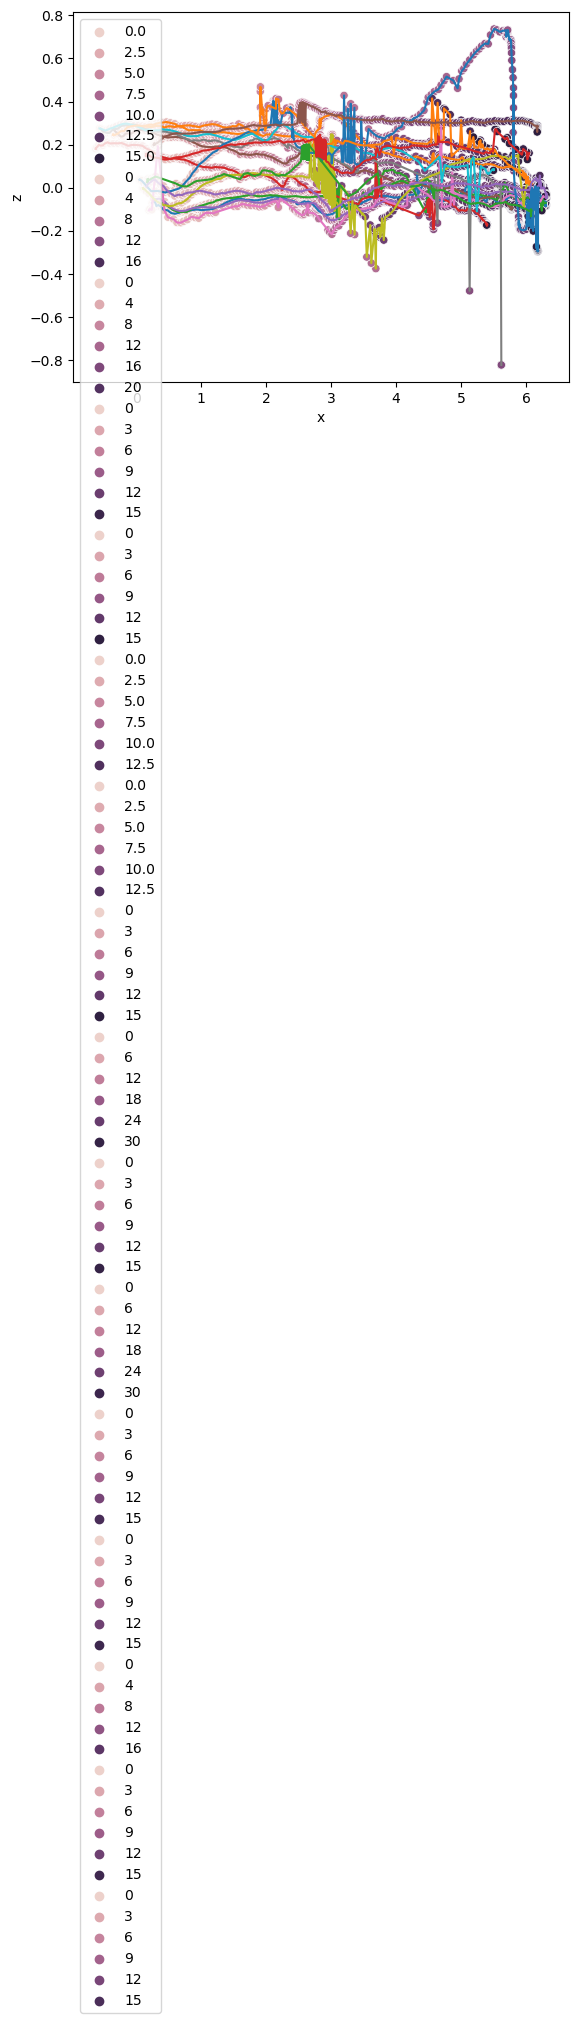

In [8]:
pp_id = '02'
position_of = 'Spot'

for i in range (1, 17):
    df_traj = pd.read_csv('./traj_data/id_' + pp_id + '/' + position_of + '/' + pp_id + '_' + str(i) + '.csv')
    print(df_traj)
    
    sns.scatterplot(data = df_traj.loc[: , ['x', 'z', 'time']], x = 'x', y = 'z', hue = 'time' )
    sns.lineplot(data = df_traj.loc[: , ['x', 'z', 'time']], x = 'x', y = 'z')
